In [1]:
# need modify trainer.py, photoarraydataset

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from torch import nn
import numpy as np

In [2]:
from model import MultiHeadMLP, MLP
from dataset import PhotoArrayDataset, MultiPhotoArrayDataset

from torch.utils.data import DataLoader

In [3]:
photo_paths = [
    "/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0012_DSC09130.png",
    "/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0013_DSC09148.png",
]

dataset = PhotoArrayDataset(photo_paths[0])
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

new_dataset = MultiPhotoArrayDataset(photo_paths, force_common_size=True)
new_x = MultiPhotoArrayDataset(photo_paths, force_common_size=False)
new_dataloader = DataLoader(new_dataset, batch_size=8, shuffle=True)


In [8]:
check = new_x
print([q.shape for q in check.img_arrays])
print(len(check))

[(355, 533, 3), (387, 582, 3)]
414449


In [6]:
new_dataset.tensors["weights"]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]])

In [13]:
for batch in new_dataloader:
    break
    
for old_batch in dataloader:
    break

In [8]:
batch["weights"]

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [10]:
in_units = dataset.tensors["features"].shape[1]
n_heads = 2

hidden_units_heads = [256]
hidden_units_core = [256] * 4


mod = MultiHeadMLP(in_units, n_heads, hidden_units_heads=hidden_units_heads, hidden_units_core=hidden_units_core)
# old = MLP(in_units, hidden_units_core)
old = MultiHeadMLP(in_units, n_heads=1, hidden_units_heads=hidden_units_heads, hidden_units_core=hidden_units_core)

In [12]:
out = mod(batch["features"], batch["weights"])
out

tensor([[ 0.0968,  0.0213, -0.0243],
        [ 0.0949,  0.0256, -0.0206],
        [ 0.0958,  0.0224, -0.0231],
        [ 0.0981,  0.0282, -0.0230],
        [ 0.0956,  0.0261, -0.0210],
        [ 0.0968,  0.0254, -0.0228],
        [ 0.0987,  0.0279, -0.0221],
        [ 0.0954,  0.0257, -0.0209]], grad_fn=<AddmmBackward>)

In [19]:
check = MultiHeadMLP(2, 1, [256, 128, 64], [64, 64])
check

MultiHeadMLP(
  (heads): ModuleList(
    (0): MLP(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=64, bias=True)
        (5): ReLU()
      )
    )
  )
  (core): MLP(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)

In [26]:
check = MultiHeadMLP(2, 1, [256, 256], [256])
check2 = MultiHeadMLP(2, 1, [256], [256, 256])

In [29]:
check2

MultiHeadMLP(
  (heads): ModuleList(
    (0): MLP(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ReLU()
      )
    )
  )
  (core): MLP(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=3, bias=True)
    )
  )
)

In [14]:
out = old(old_batch["features"], old_batch["weights"])
out

tensor([[ 0.0395, -0.0020,  0.0471],
        [ 0.0381, -0.0081,  0.0483],
        [ 0.0397, -0.0020,  0.0471],
        [ 0.0418, -0.0002,  0.0476],
        [ 0.0405, -0.0014,  0.0472],
        [ 0.0369, -0.0047,  0.0474],
        [ 0.0407, -0.0033,  0.0474],
        [ 0.0358, -0.0040,  0.0475]], grad_fn=<AddmmBackward>)

In [8]:
old(batch["features"])

tensor([[-0.0377, -0.0203,  0.0018],
        [-0.0332, -0.0207,  0.0112],
        [-0.0359, -0.0193,  0.0127],
        [-0.0443, -0.0181,  0.0080],
        [-0.0412, -0.0180,  0.0109],
        [-0.0393, -0.0148,  0.0056],
        [-0.0372, -0.0194,  0.0026],
        [-0.0348, -0.0194,  0.0152]], grad_fn=<AddmmBackward>)

In [16]:
batch["features"].shape

torch.Size([8, 2])

In [23]:
h_heads = torch.stack([head(batch["features"]) for head in mod.heads])
h_heads.shape

torch.Size([3, 8, 256])

In [30]:
qq = weights.transpose(1, 0).view(3, -1, 1) * h_heads

In [33]:
torch.sum(qq, dim=0).shape

torch.Size([8, 256])

In [14]:
weights = torch.zeros((8, 3), dtype=torch.float32)
weights[:, 0] = 1.0
mod(batch["features"], weights)

tensor([[ 0.0529, -0.0184,  0.0201],
        [ 0.0517, -0.0174,  0.0214],
        [ 0.0489, -0.0196,  0.0219],
        [ 0.0525, -0.0188,  0.0204],
        [ 0.0478, -0.0204,  0.0224],
        [ 0.0510, -0.0191,  0.0208],
        [ 0.0523, -0.0186,  0.0203],
        [ 0.0495, -0.0190,  0.0216]], grad_fn=<AddmmBackward>)

In [9]:
old

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [16]:
mlp = MLP(in_units=2, hidden_units=[256] * 5)

In [17]:
mlp

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [15]:
old

MultiHeadMLP(
  (heads): ModuleList(
    (0): MLP(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ReLU()
      )
    )
  )
  (core): MLP(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): ReLU()
      (8): Linear(in_features=256, out_features=3, bias=True)
    )
  )
)

## TODO
- test run, stop after a few epochs. also do single image case to make sure still working
- weighted reconstruction
- in general, make everything able to handle multi-head - won't be backwards compatible

In [24]:
x = np.arange(12).reshape(3, 4)
y = x.copy()
y += 10

[autoreload of dataset failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: __init__() requires a code object with 0 free vars, not 1
]


In [23]:
np.concatenate([x])

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [21]:
y

array([[10, 11, 12, 13],
       [14, 15, 16, 17],
       [18, 19, 20, 21]])

In [31]:
new_dataset.image_sizes

[(355, 533), (387, 582)]

In [32]:
from PIL import Image
from pathlib import paths

In [33]:
photo_paths

['/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0012_DSC09130.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0013_DSC09148.png']

In [45]:
import cv2
from matplotlib import pyplot as plt

In [50]:
img_arrays = new_dataset.img_arrays
sizes = [img_arr.shape[:-1] for img_arr in img_arrays]
sizes = [(h * w, (h, w)) for h, w in sizes]
sizes.sort(key=lambda x: x[0])

target_h, target_w = sizes[0][1]

qq = cv2.resize(img_arrays[1], (target_w, target_h))

In [51]:
sizes

[(189215, (355, 533)), (225234, (387, 582))]

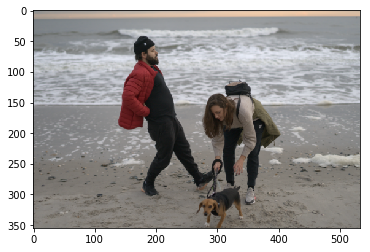

In [52]:
plt.imshow(qq)

In [ ]:
plt.imshow(qq)

In [53]:
qq.shape

(355, 533, 3)

In [54]:
img_arrays[1].shape

(387, 582, 3)

## Reconstruction

In [1]:
import numpy as np

In [31]:
import torch
from pathlib import Path

In [17]:
checkpoint_path = "/shed/data/mlp_image_reconstruction_checkpoints/ac_beach_the_family_duplex/checkpoint_00032.pt"
checkpoint_path_single = "/shed/data/mlp_image_reconstruction_checkpoints/ac_beach_the_family_single_test/checkpoint_00299.pt"

checkpoint_dir = Path("/shed/data/mlp_image_reconstruction_checkpoints/ac_beach_the_family_duplex/")
checkpoint_path = sorted(checkpoint_dir.glob("*.pt"))[-1]
checkpoint_path

PosixPath('/shed/data/mlp_image_reconstruction_checkpoints/ac_beach_the_family_duplex/checkpoint_00299.pt')

In [19]:
from reconstruct import reconstruct_single
from matplotlib import pyplot as plt

In [20]:
out_a = reconstruct_single(checkpoint_path, image_weights=[1.0, 0.0], hallucination_buffer=None)
# out_b = reconstruct_single(checkpoint_path, image_weights=[0.0, 1.0], hallucination_buffer=None)
# out_mix = reconstruct_single(checkpoint_path, image_weights=[0.5, 0.5], hallucination_buffer=100)
out_single = reconstruct_single(checkpoint_path_single)

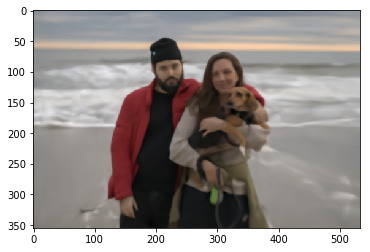

In [21]:
plt.imshow(out_a)

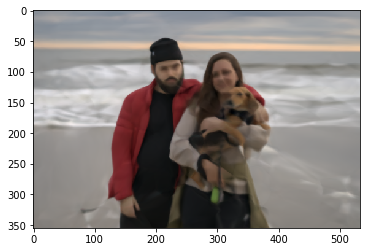

In [22]:
plt.imshow(out_single)

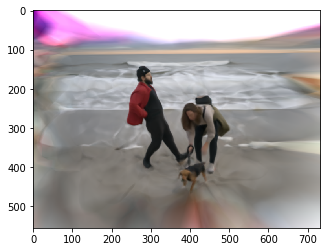

In [51]:
plt.imshow(out_b)

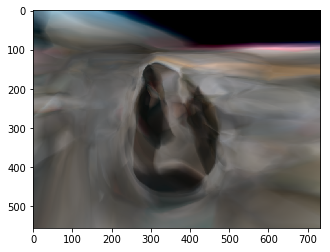

In [52]:
plt.imshow(out_mix)

In [53]:
steps = np.linspace(0, 1, 20)

In [55]:
q = np.array([1.0, 0.0]).reshape(1, -1)
p = np.array([0.0, 1.0]).reshape(1, -1)

for step in steps:
    print(q * (1 - step) + p * step)

[[1. 0.]]
[[0.94736842 0.05263158]]
[[0.89473684 0.10526316]]
[[0.84210526 0.15789474]]
[[0.78947368 0.21052632]]
[[0.73684211 0.26315789]]
[[0.68421053 0.31578947]]
[[0.63157895 0.36842105]]
[[0.57894737 0.42105263]]
[[0.52631579 0.47368421]]
[[0.47368421 0.52631579]]
[[0.42105263 0.57894737]]
[[0.36842105 0.63157895]]
[[0.31578947 0.68421053]]
[[0.26315789 0.73684211]]
[[0.21052632 0.78947368]]
[[0.15789474 0.84210526]]
[[0.10526316 0.89473684]]
[[0.05263158 0.94736842]]
[[0. 1.]]


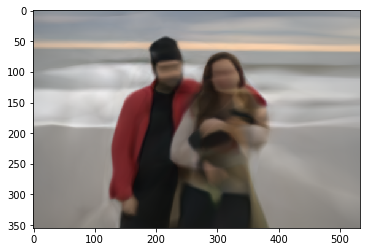

In [29]:
out_mix = reconstruct_single(checkpoint_path, image_weights=[1.0, 0.0])
plt.imshow(out_mix)

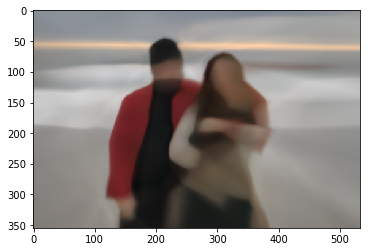

In [11]:
plt.imshow(out_single)

In [2]:
from reconstruct import reconstruct_with_image_interpolation
from pathlib import Path

In [6]:
checkpoint_dir = Path("/shed/data/mlp_image_reconstruction_checkpoints/ac_beach_set_of_eight_basic_encoding/")
checkpoint_path = sorted(checkpoint_dir.glob("*.pt"))[-1]
checkpoint_path

PosixPath('/shed/data/mlp_image_reconstruction_checkpoints/ac_beach_set_of_eight_basic_encoding/checkpoint_00003.pt')

In [7]:
output_dir = Path("/shed/data/mlp_image_reconstruction_output/")
output_dir = output_dir.joinpath(checkpoint_dir.stem + "_interpolation")
output_dir

PosixPath('/shed/data/mlp_image_reconstruction_output/ac_beach_set_of_eight_basic_encoding_interpolation')

In [8]:
reconstruct_with_image_interpolation(checkpoint_path, output_dir, hallucination_buffer=None, interpolation_steps=1, cycle=True)

In [14]:
# check reconstruction against single case

In [16]:
photos_dir = Path("/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/")
sorted(str(path) for path in photos_dir.glob("*png"))

['/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0001_DSC08626.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0002_DSC08637.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0003_DSC08664.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0004_DSC08697.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0005_DSC08835.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0006_DSC08875.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0007_DSC08911.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0008_DSC08949.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0009_DSC08976.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0010_DSC09041.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0011_DSC09073.png',
 '/shed/photo/export/atlantic_city_thanksgiving_nov2020/album/0012_DSC09130.png',
 '/shed/photo/ex